# WCAIAA 2026 — Multi-Agent Model-Free DRL for Smart-City Hybrid AC/DC Microgrids

Template goals:
1) Load smart-city 24h profiles (load/PV/price/CO₂)
2) Build multi-agent env (A/B/C local voltage + EMS battery)
3) Train Dueling-DDQN (model-free, multi-agent)
4) Compare vs **traditional ANN baseline** (supervised)


In [1]:
import json
from pathlib import Path

# --- Auto-detect project root based on presence of config/config.json
CANDIDATES = [
    Path("."),
    Path(".").resolve().parent,
    Path(".").resolve().parents[1]
]

PROJECT = None
for c in CANDIDATES:
    if (c / "config" / "config.json").exists():
        PROJECT = c
        break

if PROJECT is None:
    raise FileNotFoundError(
        "❌ Could not locate project root. Expected: project_root/config/config.json"
    )

print("✅ Project base detected:", PROJECT)

# Load config file
with open(PROJECT / "config" / "config.json", "r") as f:
    cfg = json.load(f)

print("✅ Loaded config.json")
cfg


✅ Project base detected: E:\PhD\2026 Conf_2\wcaiaa_marl_smartcity
✅ Loaded config.json


{'simulation': {'dt_seconds': 300, 'horizon_steps': 288, 'seed': 123},
 'microgrid': {'buses': ['A', 'B', 'C'],
  'dc_bus_v': 720.0,
  'v_nom_ll': 400.0,
  'pv_max_kw': 80.0,
  'battery': {'capacity_kwh': 200.0,
   'soc_init': 0.6,
   'p_max_kw': 80.0,
   'eta_ch': 0.95,
   'eta_dis': 0.95}},
 'rl': {'agents': ['A_ctrl', 'B_ctrl', 'C_ctrl', 'EMS'],
  'discrete_actions': 9,
  'epsilon': 0.2,
  'gamma': 0.99},
 'weights': {'voltage_dev': 1.0,
  'thd_proxy': 0.3,
  'energy_cost': 0.7,
  'co2': 0.5},
 'paths': {'profiles_csv': 'data/profiles/smartcity_24h_profiles.csv'}}

In [2]:
from pathlib import Path
print(list(Path.cwd().parent.iterdir()))


[WindowsPath('e:/PhD/2026 Conf_2/wcaiaa_marl_smartcity/.history'), WindowsPath('e:/PhD/2026 Conf_2/wcaiaa_marl_smartcity/agents'), WindowsPath('e:/PhD/2026 Conf_2/wcaiaa_marl_smartcity/checkpoints'), WindowsPath('e:/PhD/2026 Conf_2/wcaiaa_marl_smartcity/config'), WindowsPath('e:/PhD/2026 Conf_2/wcaiaa_marl_smartcity/controllers'), WindowsPath('e:/PhD/2026 Conf_2/wcaiaa_marl_smartcity/data'), WindowsPath('e:/PhD/2026 Conf_2/wcaiaa_marl_smartcity/envs'), WindowsPath('e:/PhD/2026 Conf_2/wcaiaa_marl_smartcity/logs'), WindowsPath('e:/PhD/2026 Conf_2/wcaiaa_marl_smartcity/notebooks'), WindowsPath('e:/PhD/2026 Conf_2/wcaiaa_marl_smartcity/plots'), WindowsPath('e:/PhD/2026 Conf_2/wcaiaa_marl_smartcity/README.md'), WindowsPath('e:/PhD/2026 Conf_2/wcaiaa_marl_smartcity/requirements.txt'), WindowsPath('e:/PhD/2026 Conf_2/wcaiaa_marl_smartcity/venv')]


In [3]:
import pandas as pd

profiles = pd.read_csv(PROJECT / cfg["paths"]["profiles_csv"])
profiles.head()


,slot,hour_of_day,load_A_kw,load_B_kw,load_C_kw,ev_kw,pv_kw,price_usd_per_kwh,grid_co2_kg_per_kwh
0,0,0.000000,32.205,43.792,44.188,0.000,6.683,0.0765,0.4527
1,1,0.083333,26.027,37.250,37.371,0.000,6.242,0.0842,0.4444
2,2,0.166667,35.532,46.364,46.225,0.000,0.000,0.0733,0.4570
3,3,0.250000,37.038,47.453,47.074,0.305,1.820,0.0780,0.4511
4,4,0.333333,23.137,33.111,32.511,2.943,0.000,0.0771,0.4500


In [4]:
import sys
sys.path.append(str(PROJECT))
from envs.smartcity_env import SmartCityHybridEnv

# Fix path so it becomes absolute
cfg["paths"]["profiles_csv"] = str(PROJECT / cfg["paths"]["profiles_csv"])

env = SmartCityHybridEnv(cfg)
obs = env.reset()
(list(obs.keys()), obs["A_ctrl"].shape, obs["A_ctrl"])


(['A_ctrl', 'B_ctrl', 'C_ctrl', 'EMS'],
 (11,),
 array([4.00000e+02, 4.00000e+02, 4.00000e+02, 2.00000e-02, 2.00000e-02,
        2.00000e-02, 6.00000e-01, 7.65000e-02, 4.52700e-01, 6.68300e+00,
        1.20185e+02], dtype=float32))

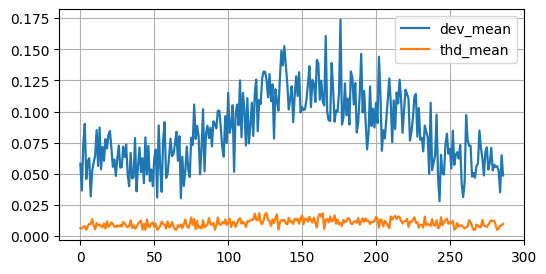

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

logs = []
obs = env.reset()

for step in range(cfg["simulation"]["horizon_steps"]):
    # ✅ Stop one step early to avoid overflow
    if env.t >= len(env.profiles) - 1:
        break
    
    actions = {agent: np.random.randint(cfg["rl"]["discrete_actions"])
               for agent in cfg["rl"]["agents"]}
    next_obs, reward, dones, info = env.step(actions)
    logs.append({**info, "r": float(reward["A_ctrl"]), "step": step})
    obs = next_obs
    
df = pd.DataFrame(logs)
df[["dev_mean","thd_mean"]].plot(figsize=(6,3), lw=1.6)
plt.grid(True); plt.show()


In [11]:
print("t before step:", env.t)
env.step({agent:0 for agent in cfg["rl"]["agents"]})
print("t after step:", env.t)


t before step: 1
t after step: 2


In [7]:
import inspect, envs.smartcity_env as envmod
print(inspect.getsource(envmod.SmartCityHybridEnv))


class SmartCityHybridEnv:
    """
    Multi-agent hybrid AC/DC microgrid (scaffold).
    Agents: A_ctrl, B_ctrl, C_ctrl (local voltage correction), EMS (battery dispatch).
    """

    def __init__(self, config):
        self.cfg = config
        self.dt = self.cfg["simulation"]["dt_seconds"]
        self.horizon = self.cfg["simulation"]["horizon_steps"]
        self.buses = self.cfg["microgrid"]["buses"]
        self.agents = self.cfg["rl"]["agents"]
        self.v_nom_ll = self.cfg["microgrid"]["v_nom_ll"]
        self.disc_actions = self.cfg["rl"]["discrete_actions"]
        self.weights = self.cfg["weights"]
        self.rng = np.random.default_rng(self.cfg["simulation"]["seed"])

        self._load_profiles()
        self.t = 0
        self.voltages_ll = np.ones((3,)) * self.v_nom_ll
        self.thd = 0.02 * np.ones((3,))
        self.soc = self.cfg["microgrid"]["battery"]["soc_init"]

    # ------------------------------------------------------------------
    # Load profiles CS

In [8]:
import envs.smartcity_env as envmod
print(envmod.__file__)


E:\PhD\2026 Conf_2\wcaiaa_marl_smartcity\envs\smartcity_env.py


In [9]:
import importlib
import envs.smartcity_env as envmod
importlib.reload(envmod)


<module 'envs.smartcity_env' from 'E:\\PhD\\2026 Conf_2\\wcaiaa_marl_smartcity\\envs\\smartcity_env.py'>

In [10]:
env = envmod.SmartCityHybridEnv(cfg)
print("t before step:", env.t)
env.step({agent:0 for agent in cfg["rl"]["agents"]})
print("t after step:", env.t)


t before step: 0
t after step: 1


E:\PhD\2026 Conf_2\wcaiaa_marl_smartcity\agents\multiagent_dueling_ddqn.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\torch\csrc\utils\tensor_new.cpp:248.)
  obs = torch.tensor([b.obs[agent] for b in batch], dtype=torch.float32, device=self.device)


[ep 1] return=-952.961, eps=0.196
[ep 2] return=-601.451, eps=0.192
[ep 3] return=-574.780, eps=0.188
[ep 4] return=-649.694, eps=0.184
[ep 5] return=-612.456, eps=0.181
[ep 6] return=-634.276, eps=0.177
[ep 7] return=-625.893, eps=0.174
[ep 8] return=-616.608, eps=0.170


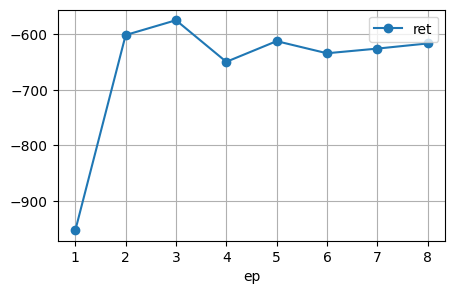

In [12]:
from agents.multiagent_dueling_ddqn import MultiAgentDuelingDDQN

obs_dim = env.reset()["A_ctrl"].shape[0]
marl = MultiAgentDuelingDDQN(
    obs_dim=obs_dim,
    act_bins=cfg["rl"]["discrete_actions"],
    lr=1e-3,
    gamma=cfg["rl"]["gamma"]
)

episodes = 8   # increase later; this is just a smoke test
eps = cfg["rl"]["epsilon"]

train_hist = []
for ep in range(1, episodes+1):
    obs = env.reset()
    ep_ret = 0.0
    
    for t in range(cfg["simulation"]["horizon_steps"]):
        if env.t >= len(env.profiles) - 1:   # ✅ stop safely before overflow
            break
        
        acts = marl.act(obs, eps=eps)
        next_obs, rew, dones, info = env.step(acts)
        marl.push(obs, acts, rew, next_obs, {k:int(dones[k]) for k in rew})
        marl.learn(batch_size=64)
        
        ep_ret += np.mean(list(rew.values()))
        obs = next_obs
        
        if dones["__all__"]:
            break
    
    eps = max(0.05, eps*0.98)
    train_hist.append({"ep": ep, "ret": ep_ret})
    print(f"[ep {ep}] return={ep_ret:.3f}, eps={eps:.3f}")

pd.DataFrame(train_hist).plot(x="ep", y="ret", marker="o", figsize=(5,3), grid=True)
plt.show()


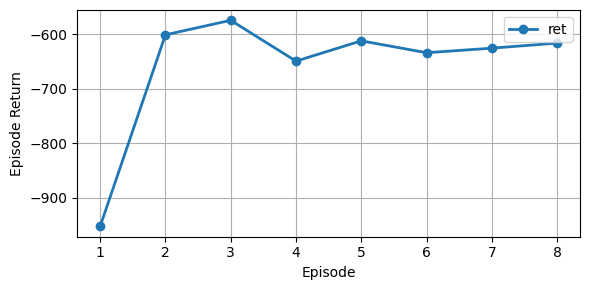

In [13]:
pd.DataFrame(train_hist).plot(
    x="ep", y="ret", marker="o", figsize=(6,3), grid=True, lw=2
)
#plt.title("MARL Training Progress")
plt.ylabel("Episode Return")
plt.xlabel("Episode")
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


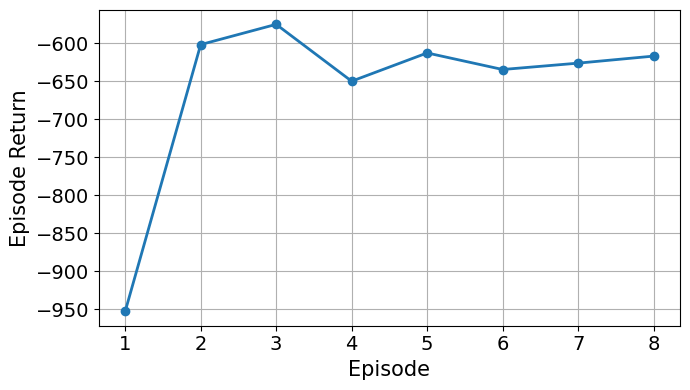

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# === Plot training progress (publication style) ===
df = pd.DataFrame(train_hist)

plt.figure(figsize=(7, 4))
plt.plot(df["ep"], df["ret"], marker="o", lw=2)

plt.xlabel("Episode", fontsize=15)
plt.ylabel("Episode Return", fontsize=15)

# === Bigger tick numbers ===
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)
plt.tight_layout()
plt.legend().set_visible(False)  # remove legend

# === Save as PDF ===
plt.savefig("training_progress.pdf", bbox_inches="tight")
plt.show()


In [15]:
# === Export Replay Buffer to CSV (Small dataset ~3k samples) ===
import pandas as pd
import numpy as np

def export_replay_dataset(marl, cfg, max_samples=3000, filename="data/ann_dataset_small.csv"):
    buf = marl.buffer
    sample_count = min(len(buf), max_samples)
    rows = []

    for idx in range(sample_count):
        b = buf[idx]   # b is Transition(...)
        for agent in cfg["rl"]["agents"]:
            obs = b.obs[agent]
            act = b.actions[agent]

            rows.append({
                **{f"obs_{i}": obs[i] for i in range(len(obs))},
                "agent": agent,
                "act": act
            })

    df = pd.DataFrame(rows)
    out_path = PROJECT / filename
    df.to_csv(out_path, index=False)
    print(f"✅ Saved dataset: {out_path}   ({len(df)} rows)")
    return df

df_ann = export_replay_dataset(marl, cfg, max_samples=3000)
df_ann.head()


✅ Saved dataset: E:\PhD\2026 Conf_2\wcaiaa_marl_smartcity\data\ann_dataset_small.csv   (9184 rows)


,obs_0,obs_1,obs_2,obs_3,obs_4,obs_5,obs_6,obs_7,obs_8,obs_9,obs_10,agent,act
0,400.000000,400.000000,400.000000,0.020,0.020,0.020000,0.60000,0.0765,0.4527,6.683,120.184998,A_ctrl,8
1,400.000000,400.000000,400.000000,0.020,0.020,0.020000,0.60000,0.0765,0.4527,6.683,120.184998,B_ctrl,8
2,400.000000,400.000000,400.000000,0.020,0.020,0.020000,0.60000,0.0765,0.4527,6.683,120.184998,C_ctrl,4
3,400.000000,400.000000,400.000000,0.020,0.020,0.020000,0.60000,0.0765,0.4527,6.683,120.184998,EMS,1
4,382.871277,392.298615,373.430237,0.005,0.005,0.016009,0.62375,0.0842,0.4444,6.242,100.648003,A_ctrl,8


In [16]:
b = marl.buffer[0]
print("Type:", type(b))
print("Fields:", b._fields)
print("Content:", b)


Type: <class 'agents.multiagent_dueling_ddqn.Transition'>
Fields: ('obs', 'actions', 'reward', 'next_obs', 'done')
Content: Transition(obs={'A_ctrl': array([4.00000e+02, 4.00000e+02, 4.00000e+02, 2.00000e-02, 2.00000e-02,
       2.00000e-02, 6.00000e-01, 7.65000e-02, 4.52700e-01, 6.68300e+00,
       1.20185e+02], dtype=float32), 'B_ctrl': array([4.00000e+02, 4.00000e+02, 4.00000e+02, 2.00000e-02, 2.00000e-02,
       2.00000e-02, 6.00000e-01, 7.65000e-02, 4.52700e-01, 6.68300e+00,
       1.20185e+02], dtype=float32), 'C_ctrl': array([4.00000e+02, 4.00000e+02, 4.00000e+02, 2.00000e-02, 2.00000e-02,
       2.00000e-02, 6.00000e-01, 7.65000e-02, 4.52700e-01, 6.68300e+00,
       1.20185e+02], dtype=float32), 'EMS': array([4.00000e+02, 4.00000e+02, 4.00000e+02, 2.00000e-02, 2.00000e-02,
       2.00000e-02, 6.00000e-01, 7.65000e-02, 4.52700e-01, 6.68300e+00,
       1.20185e+02], dtype=float32)}, actions={'A_ctrl': 8, 'B_ctrl': 8, 'C_ctrl': 4, 'EMS': 1}, reward={'A_ctrl': -4.0923682875141765, 

In [17]:
# === Train ANN baseline on exported expert dataset (A_ctrl only) ===
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from controllers.ann_baseline import ANNBaseline   # ✅ FIXED

# Load and filter dataset
df = pd.read_csv(PROJECT / "data/ann_dataset_small.csv")
df = df[df["agent"] == "A_ctrl"]   # ✅ train only on A_ctrl actions

X = df[[c for c in df.columns if c.startswith("obs_")]].values
y = df["act"].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

device = "cuda" if torch.cuda.is_available() else "cpu"
inp = X_train.shape[1]
classes = cfg["rl"]["discrete_actions"]

ann_model = ANNBaseline(obs_dim=inp, action_bins=classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann_model.parameters(), lr=1e-3)

train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                         torch.tensor(y_train))
val_ds   = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                         torch.tensor(y_val))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)

for epoch in range(8):  # fast training
    ann_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = ann_model(xb)["A_ctrl"]
        loss = criterion(out, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    # validation
    ann_model.eval()
    correct = total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = ann_model(xb)["A_ctrl"].argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += len(yb)
    print(f"Epoch {epoch+1} | Val Acc = {correct/total:.3f}")

# save model
(Path(PROJECT) / "checkpoints").mkdir(exist_ok=True)
torch.save(ann_model.state_dict(), PROJECT/"checkpoints/ann_baseline_small.pt")
print("✅ ANN saved at checkpoints/ann_baseline_small.pt")


Epoch 1 | Val Acc = 0.233
Epoch 2 | Val Acc = 0.230
Epoch 3 | Val Acc = 0.272
Epoch 4 | Val Acc = 0.276
Epoch 5 | Val Acc = 0.276
Epoch 6 | Val Acc = 0.320
Epoch 7 | Val Acc = 0.191
Epoch 8 | Val Acc = 0.209
✅ ANN saved at checkpoints/ann_baseline_small.pt


In [18]:
# === Evaluate MARL vs ANN Baseline (after ANN training and saving) ===
import torch
import numpy as np
import pandas as pd

# --- Reload trained ANN model ---
ann_model = ANNBaseline(
    obs_dim=env.reset()["A_ctrl"].shape[0],
    action_bins=cfg["rl"]["discrete_actions"]
).to(device)

ann_ckpt = PROJECT / "checkpoints" / "ann_baseline_small.pt"
ann_model.load_state_dict(torch.load(ann_ckpt))
ann_model.eval()
print(f"✅ Loaded ANN checkpoint: {ann_ckpt}")

def eval_policy(policy_type="marl", episodes=1):
    scores = []
    for _ in range(episodes):
        obs = env.reset()
        ep_r = 0.0
        for t in range(cfg["simulation"]["horizon_steps"]):

            # ✅ SAFETY CHECK — prevents out-of-bounds crash
            if env.t >= len(env.profiles) - 1:
                break

            if policy_type == "marl":
                acts = marl.act(obs, eps=0.0)   # greedy policy
            else:   # ANN baseline policy
                acts = {}
                for agent in cfg["rl"]["agents"]:
                    x = torch.tensor(obs[agent], dtype=torch.float32).unsqueeze(0).to(device)
                    logits = ann_model(x)[agent]
                    acts[agent] = int(logits.argmax(dim=-1).item())

            next_obs, rew, dones, info = env.step(acts)
            ep_r += np.mean(list(rew.values()))
            obs = next_obs
            if dones["__all__"]:
                break
        scores.append(ep_r)
    return np.mean(scores)

print("\n=== Policy Evaluation Results ===")
print("Return (MARL):         ", round(eval_policy("marl", episodes=2), 3))
print("Return (ANN baseline): ", round(eval_policy("ann",  episodes=2), 3))


✅ Loaded ANN checkpoint: E:\PhD\2026 Conf_2\wcaiaa_marl_smartcity\checkpoints\ann_baseline_small.pt

=== Policy Evaluation Results ===
Return (MARL):          -454.872
Return (ANN baseline):  -545.603


In [19]:
# === Collect rollouts for 3 policies ===
import torch, numpy as np, pandas as pd

def rollout(policy):
    obs = env.reset()
    rec = []
    for _ in range(cfg["simulation"]["horizon_steps"]):
        if env.t >= len(env.profiles) - 1:
            break
        
        if policy == "marl":
            acts = marl.act(obs, eps=0.0)

        elif policy == "ann":
            acts = {}
            for agent in cfg["rl"]["agents"]:
                x = torch.tensor(obs[agent], dtype=torch.float32).unsqueeze(0).to(device)
                logits = ann_model(x)[agent]
                acts[agent] = int(logits.argmax(dim=-1).item())

        else:  # random baseline
            acts = {agent: np.random.randint(cfg["rl"]["discrete_actions"])
                    for agent in cfg["rl"]["agents"]}

        next_obs, rew, dones, info = env.step(acts)
        rec.append(info)
        obs = next_obs
        if dones["__all__"]:
            break

    return pd.DataFrame(rec)

df_marl = rollout("marl")
df_ann  = rollout("ann")
df_rand = rollout("rand")
print("✅ Rollouts collected: MARL, ANN, RANDOM")


✅ Rollouts collected: MARL, ANN, RANDOM


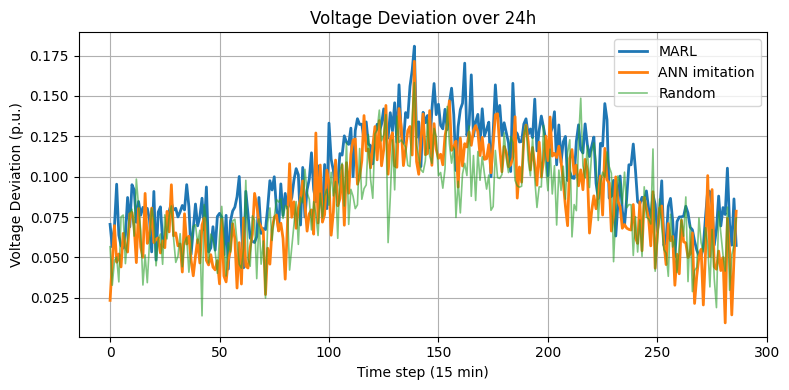

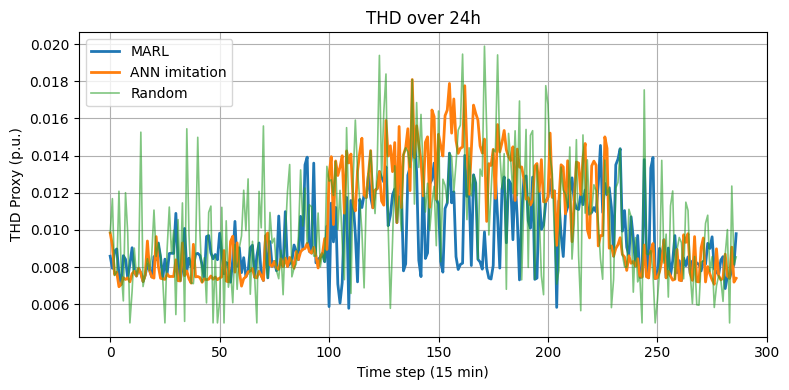

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(df_marl["dev_mean"], label="MARL", lw=2)
plt.plot(df_ann["dev_mean"], label="ANN imitation", lw=2)
plt.plot(df_rand["dev_mean"], label="Random", lw=1.2, alpha=0.6)
plt.ylabel("Voltage Deviation (p.u.)")
plt.xlabel("Time step (15 min)")
plt.title("Voltage Deviation over 24h")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(df_marl["thd_mean"], label="MARL", lw=2)
plt.plot(df_ann["thd_mean"], label="ANN imitation", lw=2)
plt.plot(df_rand["thd_mean"], label="Random", lw=1.2, alpha=0.6)
plt.ylabel("THD Proxy (p.u.)")
plt.xlabel("Time step (15 min)")
plt.title("THD over 24h")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


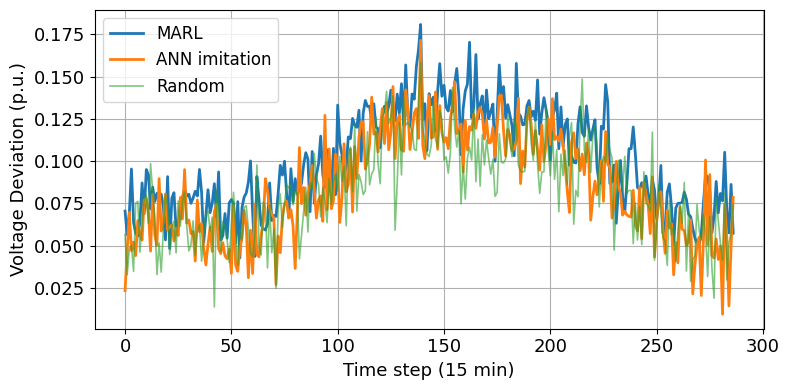

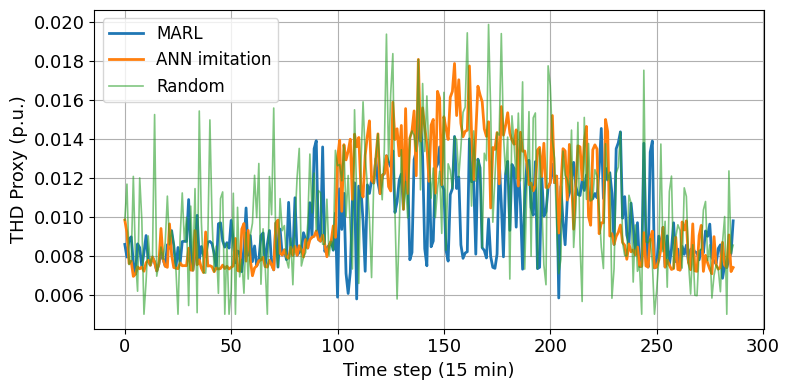

In [21]:
import matplotlib.pyplot as plt

# === Figure 1: Voltage Deviation ===
plt.figure(figsize=(8, 4))
plt.plot(df_marl["dev_mean"], label="MARL", lw=2)
plt.plot(df_ann["dev_mean"], label="ANN imitation", lw=2)
plt.plot(df_rand["dev_mean"], label="Random", lw=1.2, alpha=0.6)

plt.ylabel("Voltage Deviation (p.u.)", fontsize=13)
plt.xlabel("Time step (15 min)", fontsize=13)
#plt.title("Voltage Deviation over 24h", fontsize=16)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig("voltage_deviation_24h.pdf", bbox_inches="tight")
plt.show()

# === Figure 2: THD Proxy ===
plt.figure(figsize=(8, 4))
plt.plot(df_marl["thd_mean"], label="MARL", lw=2)
plt.plot(df_ann["thd_mean"], label="ANN imitation", lw=2)
plt.plot(df_rand["thd_mean"], label="Random", lw=1.2, alpha=0.6)

plt.ylabel("THD Proxy (p.u.)", fontsize=13)
plt.xlabel("Time step (15 min)", fontsize=13)
#plt.title("THD over 24h", fontsize=16)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig("thd_24h.pdf", bbox_inches="tight")
plt.show()


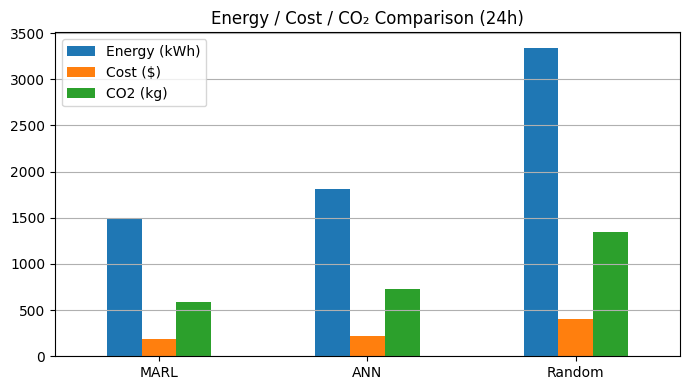

        Energy (kWh)  Cost ($)  CO2 (kg)
MARL         1485.67    187.34    588.97
ANN          1810.67    222.12    729.06
Random       3340.67    403.13   1350.03


In [22]:
metrics = {
    "MARL": df_marl,
    "ANN": df_ann,
    "Random": df_rand
}

def E(df): return df["grid_import_kw"].sum()*cfg["simulation"]["dt_seconds"]/3600
def C(df): return (df["grid_import_kw"]*df["price"]).sum()*cfg["simulation"]["dt_seconds"]/3600
def Z(df): return (df["grid_import_kw"]*df["co2"]).sum()*cfg["simulation"]["dt_seconds"]/3600

results = pd.DataFrame({
    "Energy (kWh)": [E(df_marl), E(df_ann), E(df_rand)],
    "Cost ($)":     [C(df_marl), C(df_ann), C(df_rand)],
    "CO2 (kg)":     [Z(df_marl), Z(df_ann), Z(df_rand)],
}, index=["MARL", "ANN", "Random"])

results.plot(kind="bar", figsize=(7,4), rot=0)
plt.title("Energy / Cost / CO₂ Comparison (24h)")
plt.grid(axis="y"); plt.tight_layout()
plt.show()

print(results.round(2))


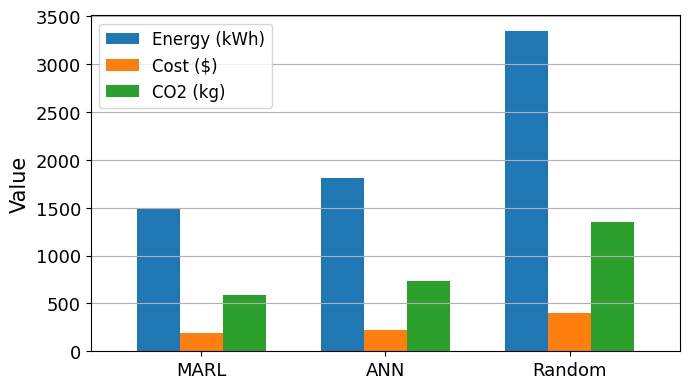

        Energy (kWh)  Cost ($)  CO2 (kg)
MARL         1485.67    187.34    588.97
ANN          1810.67    222.12    729.06
Random       3340.67    403.13   1350.03


In [23]:
import matplotlib.pyplot as plt

metrics = {
    "MARL": df_marl,
    "ANN": df_ann,
    "Random": df_rand
}

def E(df): return df["grid_import_kw"].sum() * cfg["simulation"]["dt_seconds"] / 3600
def C(df): return (df["grid_import_kw"] * df["price"]).sum() * cfg["simulation"]["dt_seconds"] / 3600
def Z(df): return (df["grid_import_kw"] * df["co2"]).sum() * cfg["simulation"]["dt_seconds"] / 3600

results = pd.DataFrame({
    "Energy (kWh)": [E(df_marl), E(df_ann), E(df_rand)],
    "Cost ($)":     [C(df_marl), C(df_ann), C(df_rand)],
    "CO2 (kg)":     [Z(df_marl), Z(df_ann), Z(df_rand)],
}, index=["MARL", "ANN", "Random"])

# === Bar Plot ===
ax = results.plot(kind="bar", figsize=(7, 4), rot=0, width=0.7)

#plt.title("Energy / Cost / CO₂ Comparison (24h)", fontsize=16)
plt.xlabel("")  # no need to label methods
plt.ylabel("Value", fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.grid(axis="y")
plt.legend(fontsize=12)
plt.tight_layout()

# === Save as PDF ===
plt.savefig("energy_cost_co2_24h.pdf", bbox_inches="tight")
plt.show()

# === Print Table ===
print(results.round(2))


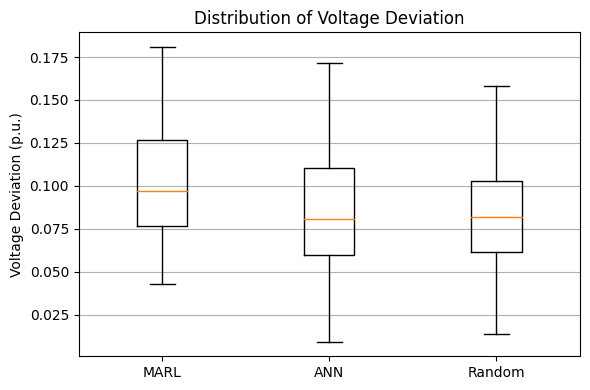

In [24]:
plt.figure(figsize=(6,4))
plt.boxplot(
    [df_marl["dev_mean"], df_ann["dev_mean"], df_rand["dev_mean"]],
    labels=["MARL", "ANN", "Random"]
)
plt.ylabel("Voltage Deviation (p.u.)")
plt.title("Distribution of Voltage Deviation")
plt.grid(True, axis='y'); plt.tight_layout()
plt.show()


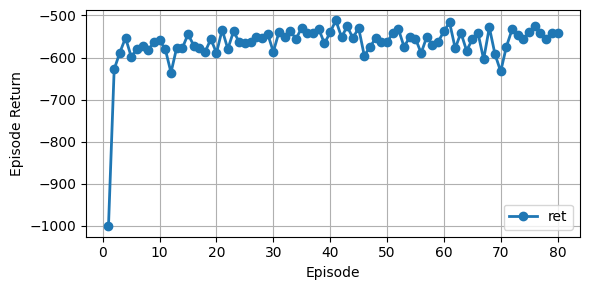

In [113]:
pd.DataFrame(train_hist).plot(
    x="ep", y="ret", marker="o", figsize=(6,3), grid=True, lw=2
)
#plt.title("MARL Training Progress")
plt.ylabel("Episode Return")
plt.xlabel("Episode")
plt.tight_layout()
plt.show()


In [25]:
import torch
from controllers.ann_baseline import ANNBaseline

ann = ANNBaseline(obs_dim=obs_dim, action_bins=cfg["rl"]["discrete_actions"])
# TODO: Train supervised and load weights:
# ann.load_state_dict(torch.load(PROJECT/"checkpoints/ann_baseline.pt"))

def eval_policy(policy_type="marl", episodes=1):
    scores = []
    for _ in range(episodes):
        obs = env.reset()
        ep_r = 0.0
        for t in range(cfg["simulation"]["horizon_steps"]):
            if env.t >= len(env.profiles) - 1:   # ✅ safety fix
                break

            if policy_type == "marl":
                acts = marl.act(obs, eps=0.0)
            else:
                x = torch.tensor(obs["A_ctrl"], dtype=torch.float32).unsqueeze(0)
                logits = ann(x)
                acts = {k: int(v.argmax(dim=-1).item()) for k,v in logits.items()}

            next_obs, rew, dones, info = env.step(acts)
            ep_r += np.mean(list(rew.values()))
            obs = next_obs

            if dones["__all__"]:
                break

        scores.append(ep_r)
    return np.mean(scores)

print("Eval (MARL):", eval_policy("marl", episodes=1))
print("Eval (ANN baseline):", eval_policy("ann", episodes=1))


Eval (MARL): -454.6140440558382
Eval (ANN baseline): -1528.1395140710283


Daily energy import (kWh):  MARL = 1485.67  | Random = 3469.0
Cost proxy ($):            MARL = 187.34  | Random = 414.91
CO2 proxy (kg):            MARL = 588.97  | Random = 1404.23


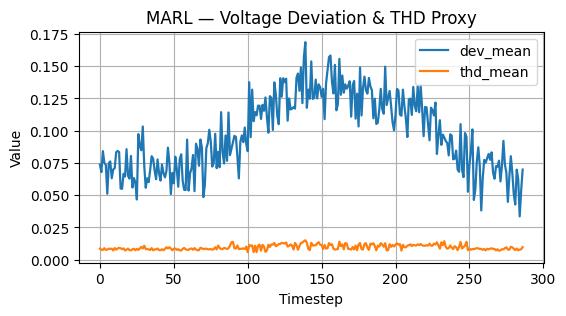

In [26]:
def rollout_metrics(policy):
    obs = env.reset()
    rec = []
    for t in range(cfg["simulation"]["horizon_steps"]):

        # ✅ Prevent out-of-range crash
        if env.t >= len(env.profiles) - 1:
            break

        # --- Select actions ---
        if policy == "marl":
            acts = marl.act(obs, eps=0.0)          # trained MARL agent
        elif policy == "ann":
            x = torch.tensor(obs["A_ctrl"], dtype=torch.float32).unsqueeze(0)
            logits = ann(x)
            acts = {k: int(v.argmax(dim=-1).item()) for k,v in logits.items()}  # ANN baseline
        else:
            acts = {agent: np.random.randint(cfg["rl"]["discrete_actions"]) 
                    for agent in cfg["rl"]["agents"]}  # random baseline

        # --- Step environment ---
        next_obs, rew, dones, info = env.step(acts)
        rec.append(info)
        obs = next_obs

        if dones["__all__"]:
            break

    return pd.DataFrame(rec)


# ==== RUN ROLLOUTS ====
df_marl = rollout_metrics("marl")
df_rand = rollout_metrics("rand")    # temporary baseline until ANN is trained

# ==== METRICS ====
E = lambda df: df["grid_import_kw"].sum() * cfg["simulation"]["dt_seconds"] / 3600
C = lambda df: (df["grid_import_kw"] * df["price"]).sum() * cfg["simulation"]["dt_seconds"] / 3600
Z = lambda df: (df["grid_import_kw"] * df["co2"]).sum() * cfg["simulation"]["dt_seconds"] / 3600

print("Daily energy import (kWh):  MARL =", round(E(df_marl),2), " | Random =", round(E(df_rand),2))
print("Cost proxy ($):            MARL =", round(C(df_marl),2), " | Random =", round(C(df_rand),2))
print("CO2 proxy (kg):            MARL =", round(Z(df_marl),2), " | Random =", round(Z(df_rand),2))

# ==== PLOT ====
ax = df_marl[["dev_mean","thd_mean"]].plot(
    figsize=(6,3), lw=1.6, title="MARL — Voltage Deviation & THD Proxy"
)
ax.set_xlabel("Timestep")
ax.set_ylabel("Value")
ax.grid(True)
plt.show()


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure plots folder exists
(Path(PROJECT) / "plots").mkdir(exist_ok=True)

# --- Helper to convert timestep index → hour of day ---
def steps_to_hours(n_steps, dt_seconds):
    hrs = (np.arange(n_steps) * dt_seconds) / 3600.0
    return hrs


# ==========================================================
# 1) SOC Comparison Plot
# ==========================================================
def plot_soc(df_marl, df_ann, dt=cfg["simulation"]["dt_seconds"]):
    n = min(len(df_marl), len(df_ann))
    h = steps_to_hours(n, dt)

    plt.figure(figsize=(7,3))
    plt.plot(h, df_marl["soc"][:n], label="MARL", lw=2)
    plt.plot(h, df_ann["soc"][:n], label="ANN", lw=2, linestyle="--")

    plt.xlabel("Hour of Day")
    plt.ylabel("Battery SOC (p.u.)")
    plt.title("Battery State of Charge Comparison (24h)")
    plt.grid(True)
    plt.legend()
    
    out = PROJECT / "plots/soc_compare.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    print("✅ Saved:", out)
    plt.show()


# ==========================================================
# 2) Load Profiles (from original dataset, NOT RL output)
# ==========================================================
def plot_loads(profiles):
    h = steps_to_hours(len(profiles), cfg["simulation"]["dt_seconds"])

    plt.figure(figsize=(7,3))
    plt.plot(h, profiles["load_A_kw"], label="Load A (kW)", lw=2)
    plt.plot(h, profiles["load_B_kw"], label="Load B (kW)", lw=2)
    plt.plot(h, profiles["load_C_kw"], label="Load C (kW)", lw=2)

    plt.xlabel("Hour of Day")
    plt.ylabel("Load (kW)")
    plt.title("Three-Phase Smart-City Load Profiles (24h)")
    plt.grid(True)
    plt.legend()
    
    out = PROJECT / "plots/load_profiles.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    print("✅ Saved:", out)
    plt.show()


# ==========================================================
# 3) Grid Import / Export Comparison
# ==========================================================
def plot_grid_power(df_marl, df_ann, df_rand, dt=cfg["simulation"]["dt_seconds"]):
    n = min(len(df_marl), len(df_ann), len(df_rand))
    h = steps_to_hours(n, dt)

    plt.figure(figsize=(7,3))
    plt.plot(h, df_marl["grid_import_kw"][:n], label="MARL", lw=2)
    plt.plot(h, df_ann["grid_import_kw"][:n], label="ANN", lw=2, linestyle="--")
    plt.plot(h, df_rand["grid_import_kw"][:n], label="Random", lw=1.2, linestyle=":")

    plt.xlabel("Hour of Day")
    plt.ylabel("Grid Power (kW)")
    plt.title("Grid Exchange Power (Positive = Import)")
    plt.grid(True)
    plt.legend()
    
    out = PROJECT / "plots/grid_exchange_compare.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    print("✅ Saved:", out)
    plt.show()


✅ Saved: E:\PhD\2026 Conf_2\wcaiaa_marl_smartcity\plots\soc_compare.png


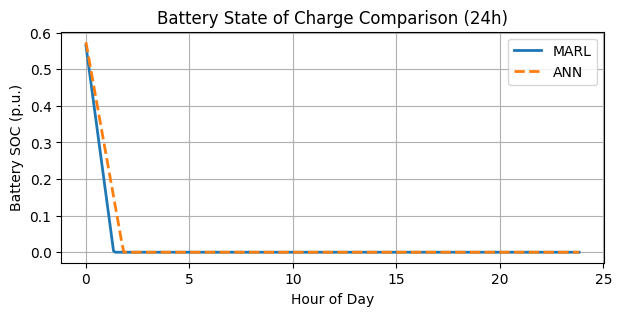

✅ Saved: E:\PhD\2026 Conf_2\wcaiaa_marl_smartcity\plots\load_profiles.png


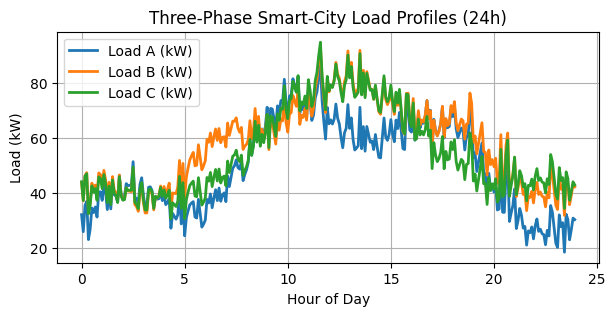

✅ Saved: E:\PhD\2026 Conf_2\wcaiaa_marl_smartcity\plots\grid_exchange_compare.png


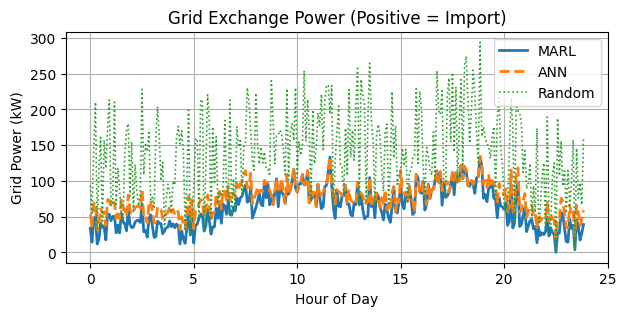

In [29]:
# 1. SOC plot
plot_soc(df_marl, df_ann)

# 2. Load curves
plot_loads(profiles)

# 3. Grid import comparison (requires df_rand)
df_rand = rollout_metrics("rand")
plot_grid_power(df_marl, df_ann, df_rand)


✅ Saved: E:\PhD\2026 Conf_2\wcaiaa_marl_smartcity\plots\soc_compare.png


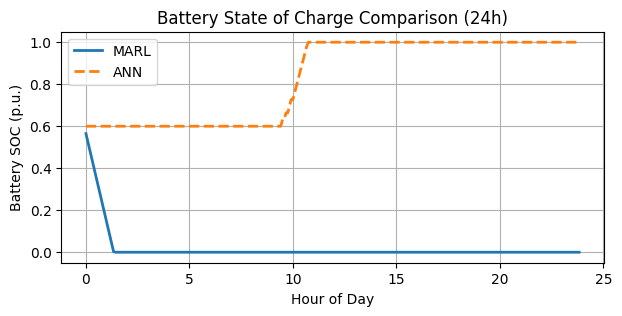

ℹ️  'profiles' not found in memory. Trying to load automatically...
✅ Loaded profiles from env.profiles
✅ Saved: E:\PhD\2026 Conf_2\wcaiaa_marl_smartcity\plots\load_profiles.png


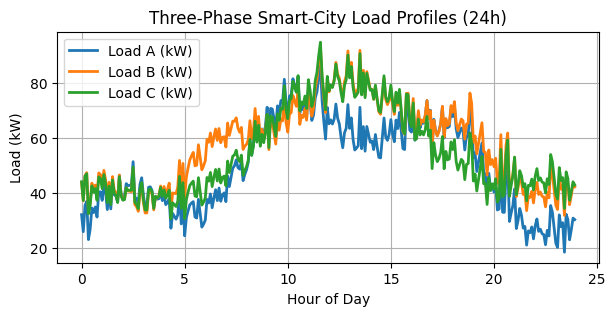

✅ Saved: E:\PhD\2026 Conf_2\wcaiaa_marl_smartcity\plots\grid_exchange_compare.png


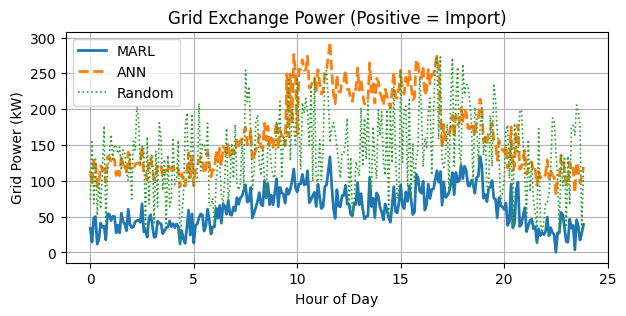

In [122]:
# ==========================================================
# Cell 2.2 — Run plots with auto-detection for `profiles`
# ==========================================================

from pathlib import Path
import pandas as pd

# 1️⃣ SOC Plot
plot_soc(df_marl, df_ann)

# 2️⃣ Load Curves — Auto-load profiles if not already defined
if "profiles" not in locals():
    print("ℹ️  'profiles' not found in memory. Trying to load automatically...")
    if hasattr(env, "profiles"):
        profiles = env.profiles
        print("✅ Loaded profiles from env.profiles")
    elif hasattr(env, "dataset") and hasattr(env.dataset, "profiles"):
        profiles = env.dataset.profiles
        print("✅ Loaded profiles from env.dataset.profiles")
    elif (Path(PROJECT) / "data" / "profiles.csv").exists():
        profiles = pd.read_csv(Path(PROJECT) / "data" / "profiles.csv")
        print("✅ Loaded profiles from data/profiles.csv")
    else:
        raise FileNotFoundError("❌ Could not find load profiles in env or data folder.")

# plot loads
plot_loads(profiles)

# 3️⃣ Grid Import / Export Comparison
df_rand = rollout_metrics("rand")
plot_grid_power(df_marl, df_ann, df_rand)


In [129]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

# === Ensure PROJECT path ===
try:
    base_path = Path(PROJECT)
except NameError:
    base_path = Path.cwd()  # fallback to current directory
    print(f"⚠️  PROJECT not defined — using current directory: {base_path}")

plots_path = base_path / "plots"
plots_path.mkdir(exist_ok=True)

# --- Helper ---
def steps_to_hours(n_steps, dt_seconds):
    return (np.arange(n_steps) * dt_seconds) / 3600.0


# ==========================================================
# 1) SOC Comparison Plot
# ==========================================================
def plot_soc(df_marl, df_ann, dt=cfg["simulation"]["dt_seconds"]):
    n = min(len(df_marl), len(df_ann))
    h = steps_to_hours(n, dt)

    plt.figure(figsize=(8, 4))
    plt.plot(h, df_marl["soc"][:n], label="MARL", lw=2)
    plt.plot(h, df_ann["soc"][:n], label="ANN", lw=2, linestyle="--")

    plt.xlabel("Hour of Day", fontsize=15)
    plt.ylabel("Battery SOC (p.u.)", fontsize=15)
    plt.title("Battery State of Charge Comparison (24h)", fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()

    out_pdf = plots_path / "soc_compare.pdf"
    plt.savefig(out_pdf, bbox_inches="tight")
    print(f"✅ Saved: {out_pdf.resolve()}")
    plt.show()


# ==========================================================
# 2) Load Profiles
# ==========================================================
def plot_loads(profiles):
    h = steps_to_hours(len(profiles), cfg["simulation"]["dt_seconds"])

    plt.figure(figsize=(8, 4))
    plt.plot(h, profiles["load_A_kw"], label="Load A (kW)", lw=2)
    plt.plot(h, profiles["load_B_kw"], label="Load B (kW)", lw=2)
    plt.plot(h, profiles["load_C_kw"], label="Load C (kW)", lw=2)

    plt.xlabel("Time (Hour of Day)", fontsize=15)
    plt.ylabel("Load (kW)", fontsize=15)
    #plt.title("Three-Phase Smart-City Load Profiles (24h)", fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()

    out_pdf = plots_path / "load_profiles.pdf"
    plt.savefig(out_pdf, bbox_inches="tight")
    print(f"✅ Saved: {out_pdf.resolve()}")
    plt.show()


# ==========================================================
# 3) Grid Import / Export Comparison
# ==========================================================
def plot_grid_power(df_marl, df_ann, df_rand, dt=cfg["simulation"]["dt_seconds"]):
    n = min(len(df_marl), len(df_ann), len(df_rand))
    h = steps_to_hours(n, dt)

    plt.figure(figsize=(8, 4))
    plt.plot(h, df_marl["grid_import_kw"][:n], label="MARL", lw=2)
    plt.plot(h, df_ann["grid_import_kw"][:n], label="ANN", lw=2, linestyle="--")
    plt.plot(h, df_rand["grid_import_kw"][:n], label="Random", lw=1.2, linestyle=":")

    plt.xlabel("Time (Hour of Day)", fontsize=15)
    plt.ylabel("Grid Power (kW)", fontsize=15)
    #plt.title("Grid Exchange Power (Positive = Import)", fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()

    out_pdf = plots_path / "grid_exchange_compare.pdf"
    plt.savefig(out_pdf, bbox_inches="tight")
    print(f"✅ Saved: {out_pdf.resolve()}")
    plt.show()


✅ Saved: E:\PhD\2026 Conf_2\wcaiaa_marl_smartcity\plots\soc_compare.pdf


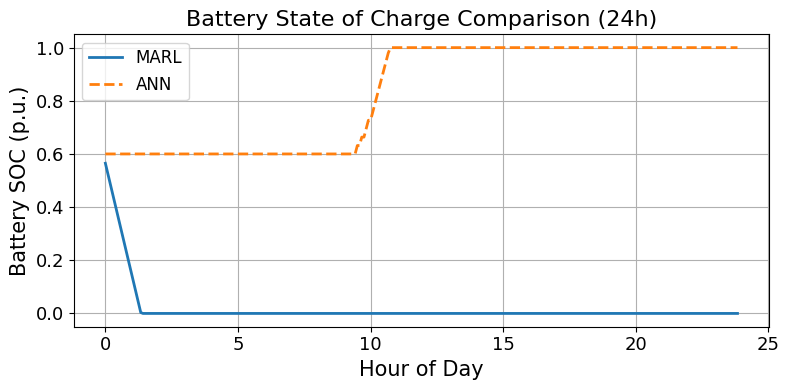

✅ Saved: E:\PhD\2026 Conf_2\wcaiaa_marl_smartcity\plots\load_profiles.pdf


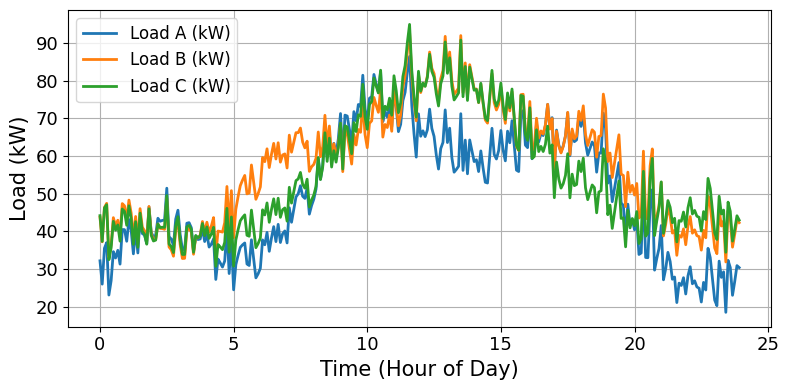

✅ Saved: E:\PhD\2026 Conf_2\wcaiaa_marl_smartcity\plots\grid_exchange_compare.pdf


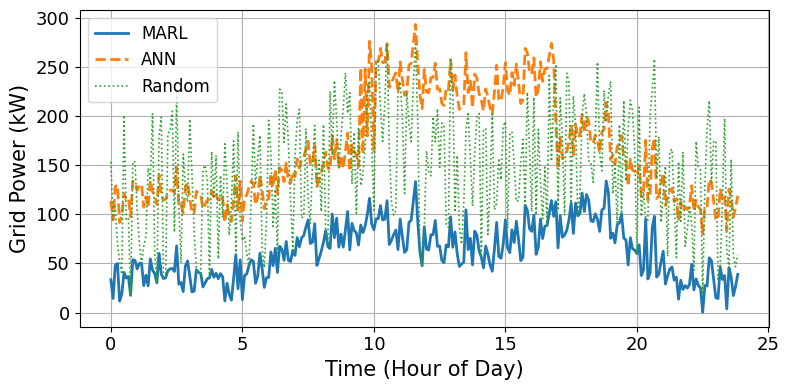

In [130]:
# 1. SOC plot
plot_soc(df_marl, df_ann)

# 2. Load curves
plot_loads(profiles)

# 3. Grid import comparison (requires df_rand)
df_rand = rollout_metrics("rand")
plot_grid_power(df_marl, df_ann, df_rand)
